## Analysis of the published data
In this notebook we analyze the CPC scores and their components, which a published every year by INEP. We first focus on the CPC scores, and their most import components, the ENADE score and the IDD scores. We will show that the CPC shows low correlations between the scores of the same courses assesed in 2014 and 2017. This is due for the most part to the IDD component (35% of the total CPC score). 

In comparing the data from 2014 and 2017 there is a restriction, as noted in the CreateDataset notebook: in 2014 results were still reported for the so-called "Unit of observation" instead of individual courses. Therefore, in this notebook we only compare combinations of area / institutions / municipalities with only one course, so that we can unambiguously compare 2014 and 2017.  

In [110]:
import pandas as pd
import seaborn as sns
import amatplotlib.pyplot as plt
import numpy as np

In [191]:
cpc17 = pd.read_csv('data/processed/cpc-pub-2017.csv')
cpc14 = pd.read_csv('data/processed/cpc-pub-2014.csv')

def filtered(df):
    df = df[df['N'] > 1]
    df = df[df['fracN'] > 0.2]
    return df
cpc17 = filtered(cpc17)
cpc14 = filtered(cpc14)

In [184]:
areas17 = {21:'Arquitetura e Urbanismo',
         72:'Tecnologia em Análise e Desenvolvimento de Sistemas',
         76:'Tecnologia em Gestão da Produção Industrial',
         79:'Tecnologia em Redes de Computadores',
         701:'Matemática (Bacharelado)',
         702:'Matemática (Licenciatura)',
         903:'Letras-Português (Bacharelado)',
         904:'Letras-Português (Licenciatura)',
         905:'Letras-Português e Inglês (Licenciatura)',
         906:'Letras-Português e Espanhol (Licenciatura)',
         1401:'Física (Bacharelado)',
         1402:'Física (Licenciatura)',
         1501:'Química (Bacharelado)',
         1502:'Química (Licenciatura)',
         1601:'Ciências Biológicas (Bacharelado)',
         1602:'Ciências Biológicas (Licenciatura)',
         2001:'Pedagogia (Licenciatura)',
         2401:'História (Bacharelado)',
         2402:'História (Licenciatura)',
         2501:'Artes Visuais (Licenciatura)',
         3001:'Geografia (Bacharelado)',
         3002:'Geografia (Licenciatura)',
         3201:'Filosofia (Bacharelado)',
         3202:'Filosofia (Licenciatura)',
         3502:'Educação Física (Licenciatura)'
}

In [185]:
def random_averages(Ns=[],mu=0,sigma=1):
    'returns an array of averages, given an array of Ns'
    Ns = [round(N) for N in Ns]
    return [np.random.normal(mu,sigma,N).mean() for N in Ns]

random_averages([2,3.0,4,52])
    

[0.6518799588467789,
 1.0745735440043174,
 0.30101951756716316,
 0.3896150403163569]

1193183


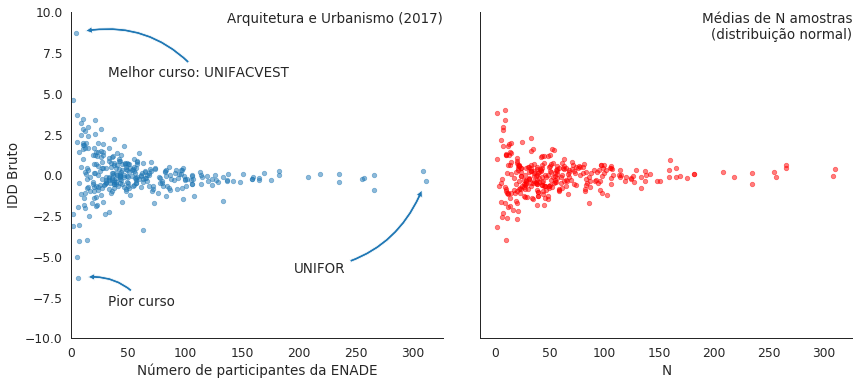

In [266]:
def rankfig(area,ano,jittered = True,indicator='idd'):
    if ano == 2017:
        r = cpc17.query("area == @area")
    else:
        r = cpc14.query("area == @area")
    r = r.sort_values('N')
    r = r[abs(r['idd']) < 10]
    if jittered:
        r['x'] = r['N'].apply(np.random.normal,scale=0.5)
    else:
        r['x'] = r['N']
    if indicator == 'idd':
        r['simulated'] = random_averages(r['x'],mu=0,sigma=5)
    elif indicator in ['cpc','enade']:
        r['simulated'] = random_averages(r['x'],mu=2.5,sigma=2)
    
    sns.set_style('white')
    sns.set_context('paper',font_scale=1.4)
    #fig = plt.figure(figsize=(8,5))
    _,axs = plt.subplots(1,2,figsize=(14,6),sharey=True)
    ax = axs[0]
    r.plot(kind='scatter',x='x',y=indicator,alpha=0.5,ax=ax)
    if indicator == 'idd':
        ax.set_ylim(-10,10)
        ax.set_ylabel("IDD Bruto")
    elif indicator == 'cpc':
        ax.set_ylim(0,5)
        ax.set_ylabel("CPC")
    elif indicator == 'enade':
        ax.set_ylim(0,5)
        ax.set_ylabel("ENADE")
    
    ax.set_xlabel('Número de participantes da ENADE')
    ax.set_xlim(0)
    ax.text(1,1,areas17[area] +" ("+str(ano)+")",
            horizontalalignment='right',
            verticalalignment='top',transform=ax.transAxes)
    if area == 21 and ano == 2017 and indicator in ['cpc','idd']:
        lastx = r['x'].iloc[-1];lasty = r[indicator].iloc[-1]
        firstx = r['N'].loc[r[indicator].idxmax()];firsty = r[indicator].max()
        worstx = r['N'].loc[r[indicator].idxmin()];worsty = r[indicator].min()
        #last_course = r['curso'].iloc[-1]
        first_course = r['curso'].loc[r[indicator].idxmax()]
        worst_course = r['curso'].loc[r[indicator].idxmin()]
        print(worst_course)
    
        ax.annotate("UNIFOR",(lastx,lasty),xytext=(0.6,0.2),
                    textcoords='axes fraction',
                    arrowprops={'arrowstyle':'simple',
                                'connectionstyle':'arc3,rad=0.3',
                                'shrinkB':10})
        ax.annotate('Melhor curso: UNIFACVEST',(firstx,firsty),xytext=(0.1,0.8),
                    textcoords='axes fraction',
                    arrowprops={'arrowstyle':'simple',
                                'connectionstyle':'arc3,rad=0.3',
                                'shrinkB':10})
        ax.annotate('Pior curso',(worstx,worsty),xytext=(0.1,0.1),
                    textcoords='axes fraction',
                    arrowprops={'arrowstyle':'simple',
                                'connectionstyle':'arc3,rad=0.3',
                                'shrinkB':10})
    sns.despine()
    
    ax = axs[1]
    r.plot(kind='scatter',x='x',y='simulated',alpha=0.5,color='r',ax=ax)
    ax.set_xlabel('N')
    ax.set_ylabel('')
    ax.text(1,1,"Médias de N amostras\n(distribuição normal)",
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)

    plt.subplots_adjust(wspace=0.1)
    
rankfig(21,2017,jittered=False,indicator='idd')

In [165]:
cpc17['idd'].idxmax()

6483

In [197]:
df = pd.merge(cpc14[cpc14['Ncursos'] == 1],cpc17,on=['area','ies','municipio'],how='inner',validate='1:m')
df.rename(columns={'idd_x':'idd14','idd_y':'idd17','cpc_x':'cpc14','cpc_y':'cpc17',
                   'enade_x':'enade14','enade_y':'enade17',
                    'Ncp_x':'Ncp14','Ncp_y':'Ncp17'},
                    inplace=True)
print("courses: ",len(df),"areas: ",df.area.nunique())

courses:  5543 areas:  40


In [198]:
df.sample(5)

,area,ies,municipio,Ncursos,Nci_x,Ncp14,enade14,N_x,fracN_x,idd14,...,curso,Nci_y,Ncp17,enade17,N_y,fracN_y,idd17,cpc17,cpcf_y,ano_y
5232,6208,2564,2516300,1,11,11,1.397042,5,0.454545,2.739037,...,1106578,34,33,2.310023,31.0,0.939394,-0.087621,2.658515,3,2017
4932,5902,1598,3170206,1,45,41,0.474923,15,0.365854,-1.186522,...,116688,91,48,1.393116,27.0,0.562500,-0.213519,2.752227,3,2017
3858,4004,591,3549904,1,102,75,2.101328,36,0.480000,-4.068468,...,110528,45,38,4.314805,14.0,0.368421,-0.107042,3.651907,4,2017
2632,2001,3612,3556206,1,53,46,1.622911,25,0.543478,-2.523054,...,100497,35,23,2.127741,10.0,0.434783,0.956648,2.357297,3,2017
3203,3002,1538,5300108,1,3,3,3.359211,2,0.666667,7.027036,...,54672,19,14,3.116483,7.0,0.500000,3.642266,4.030435,5,2017


In [251]:
df[['idd14','idd17']].corr()

,idd14,idd17
idd14,1.000000,0.218372
idd17,0.218372,1.000000


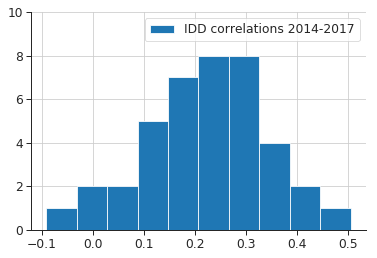

In [284]:
corrs = df[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
corrs.hist(label="IDD correlations 2014-2017")
ax = plt.gca()
ax.set_ylim(0,10)
plt.legend()
sns.despine()

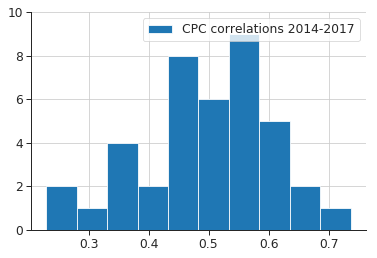

In [285]:
corrs = df[['area','cpc14','cpc17']].groupby('area').corr().iloc[0::2,-1].sort_values()
corrs.hist(label="CPC correlations 2014-2017")
ax = plt.gca()
ax.set_ylim(0,10)
plt.legend()
sns.despine()

/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


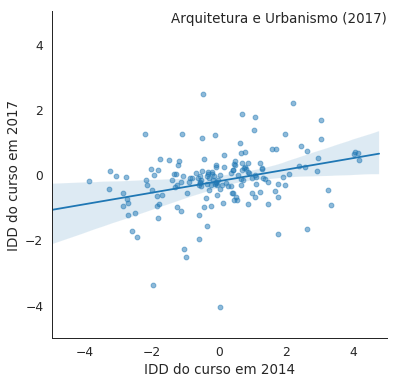

In [274]:
fig = plt.figure(figsize=(6,6))
sns.regplot(data=df.query("area == 21"),x='idd14',y='idd17',scatter_kws={'alpha':0.5})
ax = plt.gca()
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_xlabel("IDD do curso em 2014")
ax.set_ylabel("IDD do curso em 2017")
ax.text(1,1,areas17[21] +" ("+str(2017)+")",
            horizontalalignment='right',
            verticalalignment='top',transform=ax.transAxes);
sns.despine()

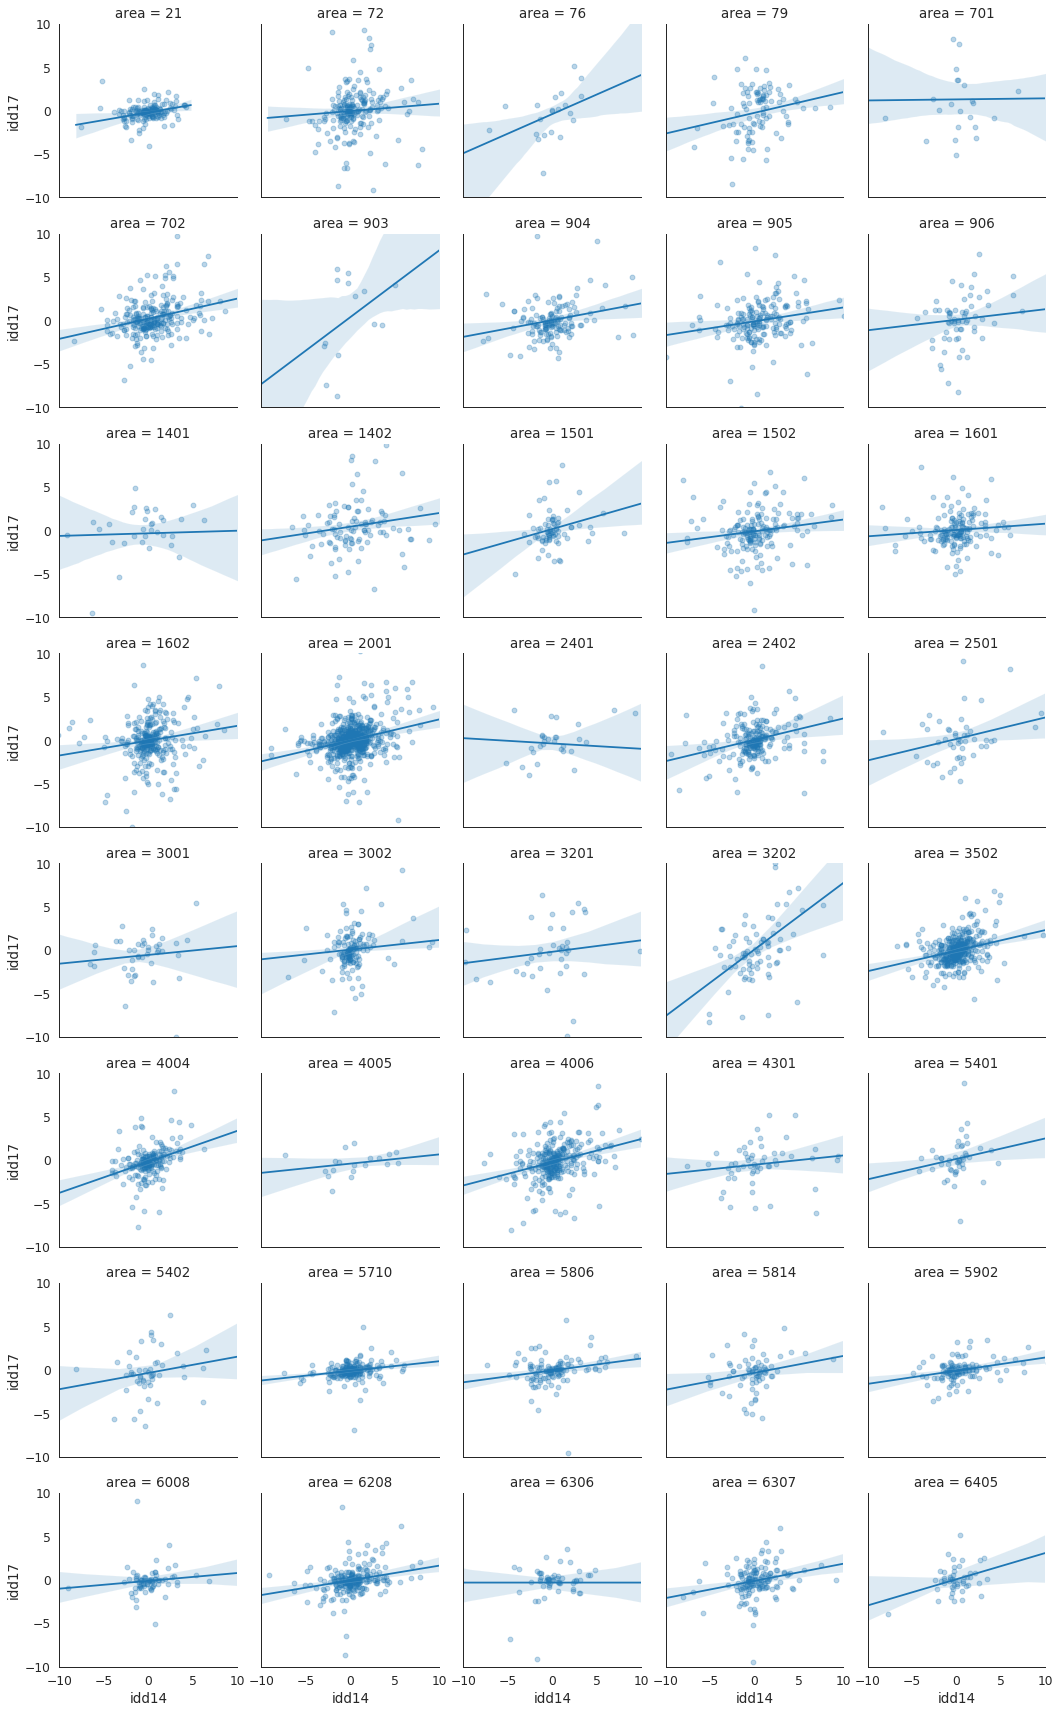

In [241]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(sns.regplot,'idd14','idd17',scatter_kws={'alpha':0.3});
g.set(xlim=(-10,10))
g.set(ylim=(-10,10))

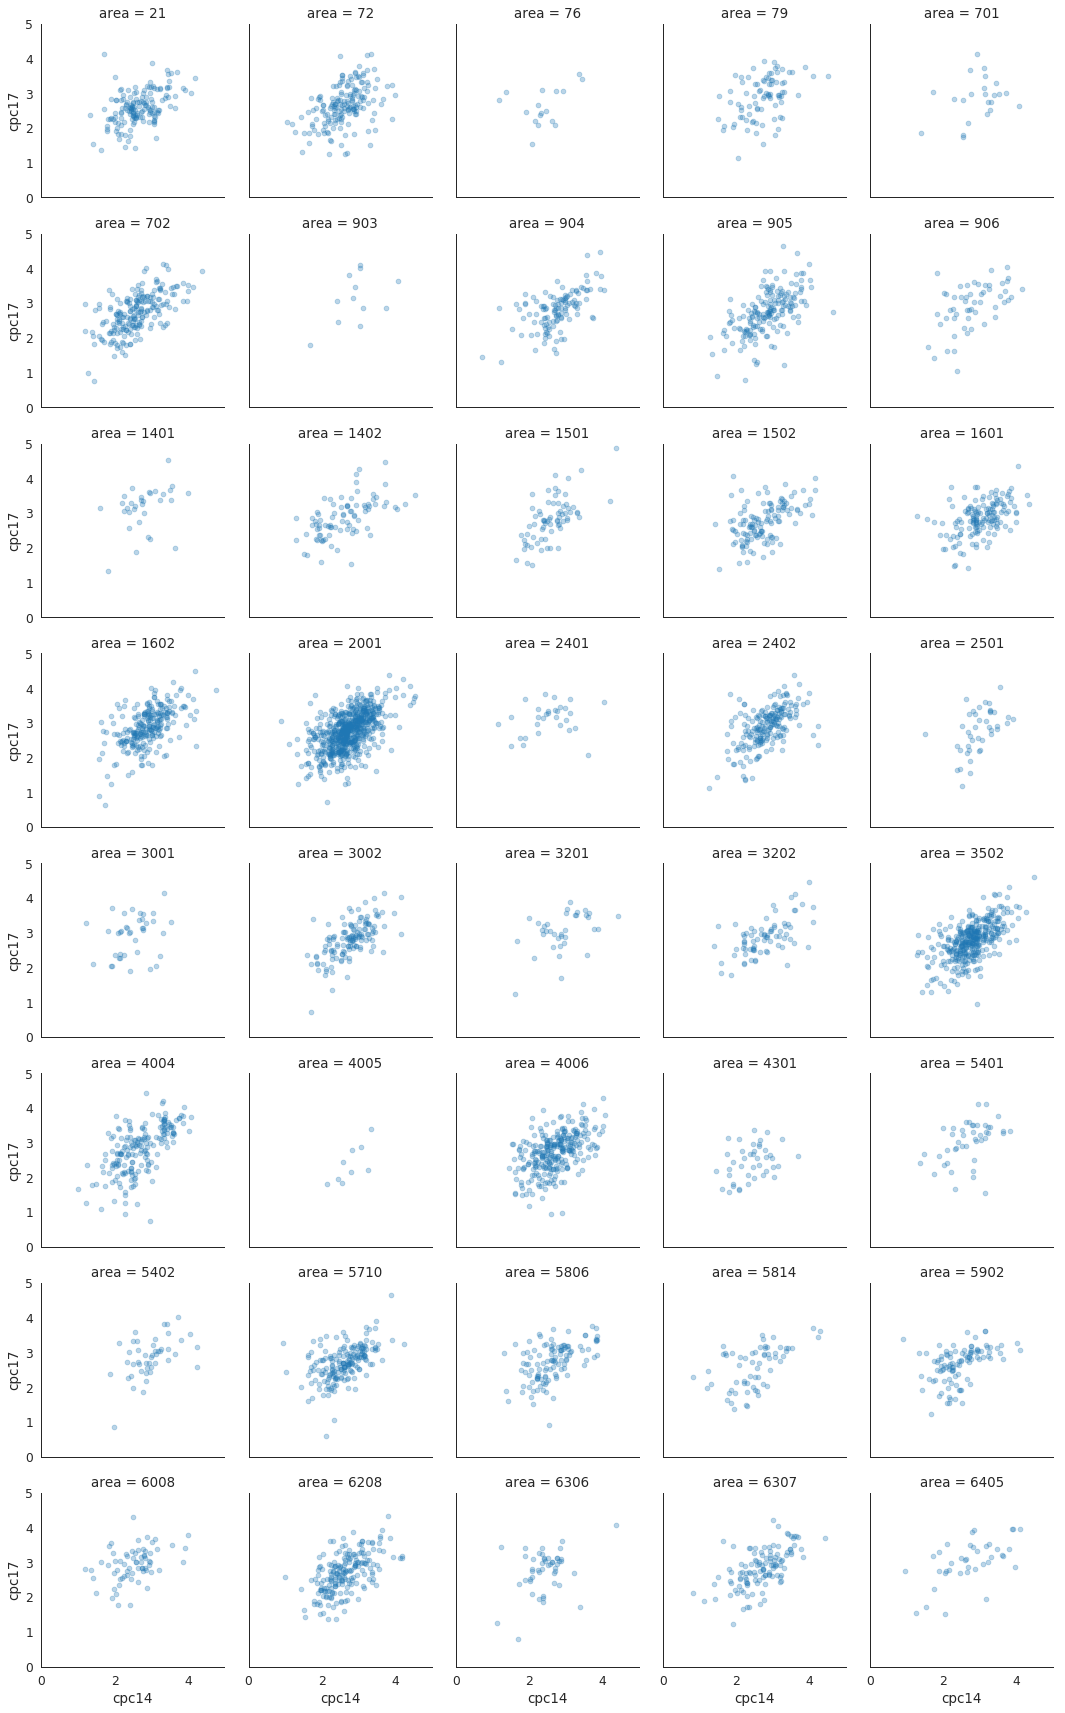

In [122]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'cpc14','cpc17',alpha=0.3);
g.set(xlim=(0,5))
g.set(ylim=(0,5))

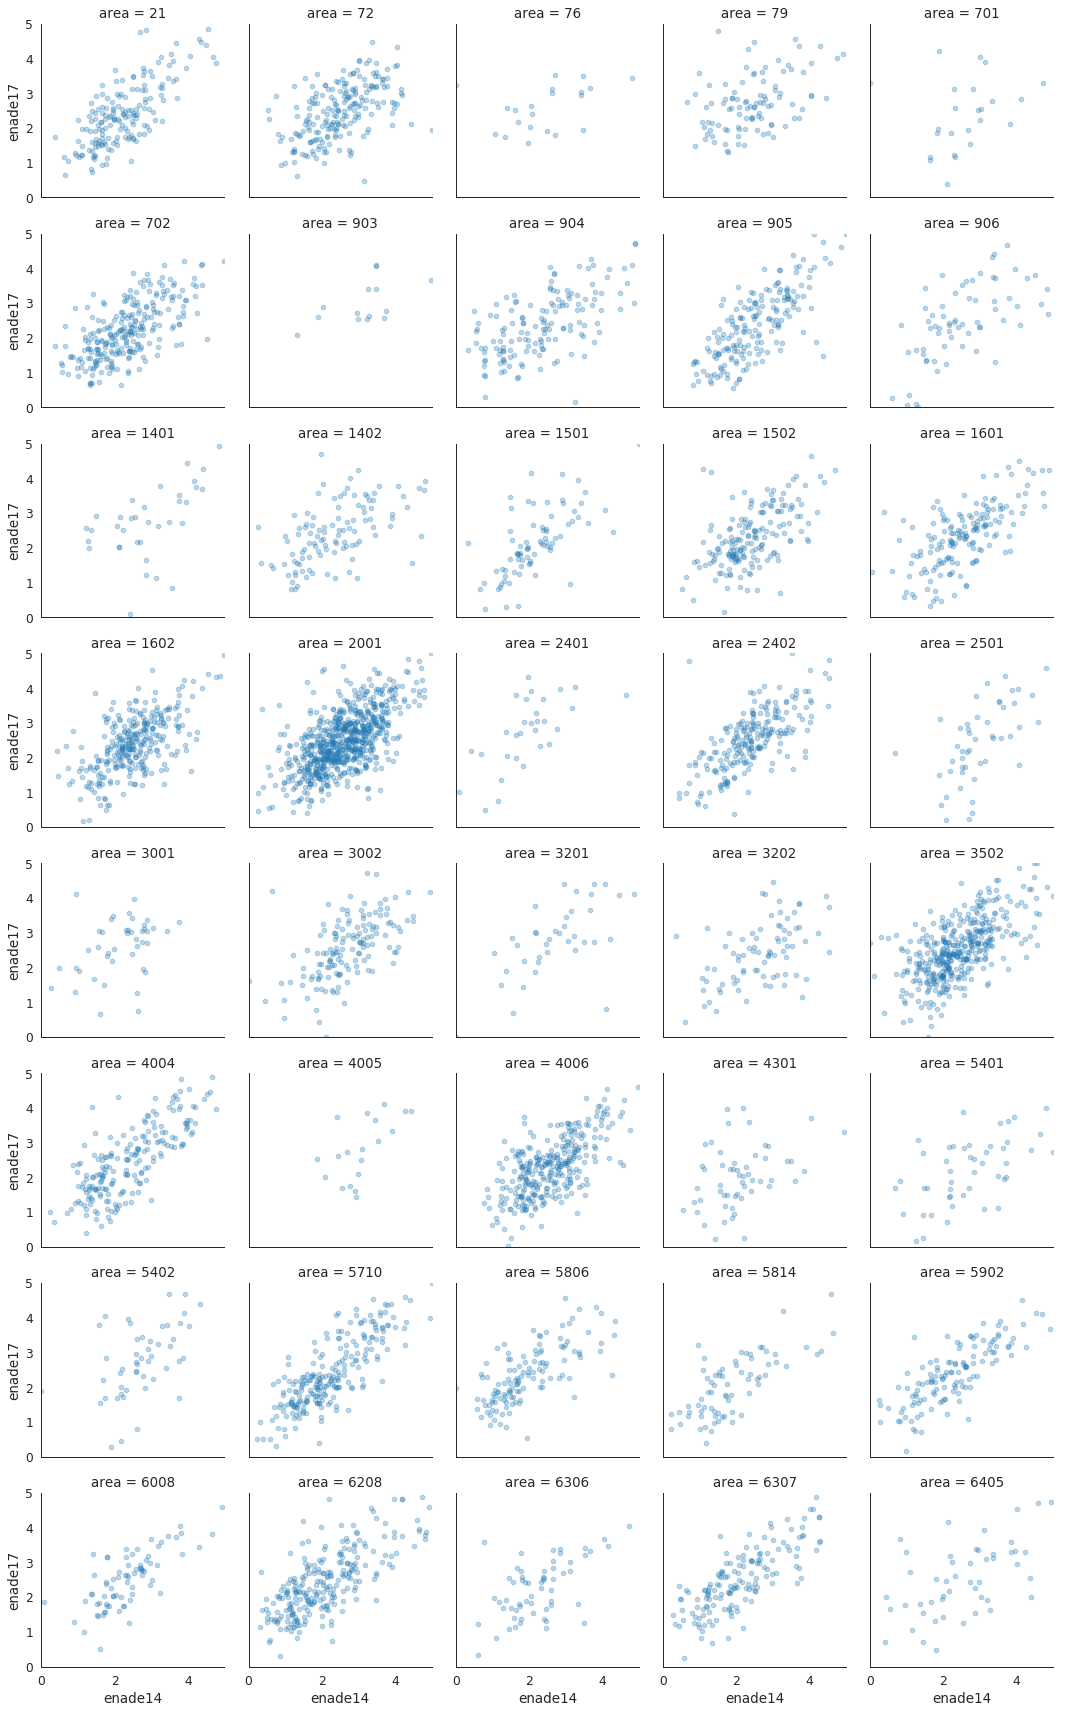

In [196]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'enade14','enade17',alpha=0.3);
g.set(xlim=(0,5))
g.set(ylim=(0,5))

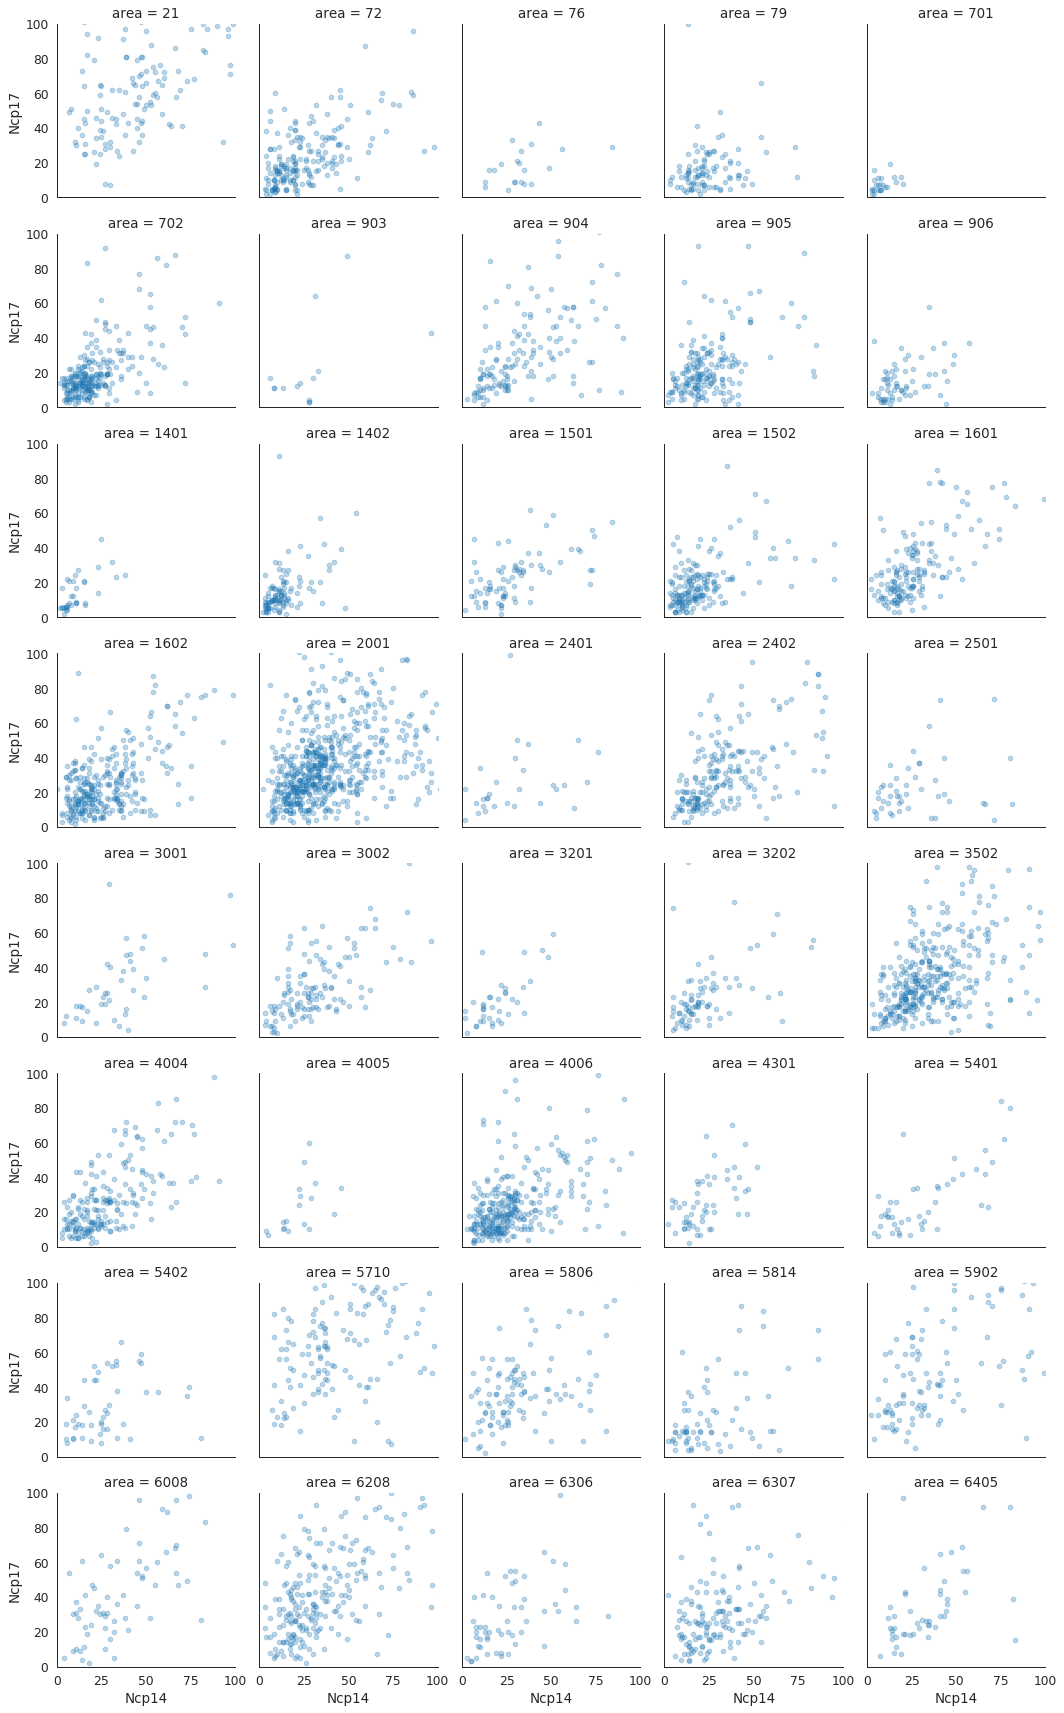

In [199]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'Ncp14','Ncp17',alpha=0.3);
g.set(xlim=(0,100))
g.set(ylim=(0,100))